In [1]:
import numpy as np
from scipy import fft, optimize
import statistics as st
import matplotlib.pyplot as plt
from IPython.display import display, Math
import re 

# Data

In [2]:
Name_xbpms = []
Name_ybpms = []
Pos_xbpms = np.zeros([1024, 168])
Pos_ybpms = np.zeros([1024, 167])
S_xbpms = np.zeros([1024, 168])
S_ybpms = np.zeros([1024, 167])
with open('data_Wed_Jun_28_20-13-14_2023') as output:
    Lines = output.readlines()
    index_ix = index_jx = 0
    index_iy = index_jy = 0
    init_i = 414
    for i, line in enumerate(Lines[1:]):
        Line = []
        #xBPM Names
        if i >= 67 and i < 95:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_xbpms.append(Line[:-1])
        
        #yBPM Names
        if i >= 241 and i < 269:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_ybpms.append(Line[:-1])
           
        #s and positions for xBPM
        if i > init_i:
            row = re.split("\s+", line)
            S_xbpms[index_ix][index_jx] = float(row[1])
            Pos_xbpms[index_ix][index_jx] = float(row[2])
            index_jx = (i - init_i)%168
            
            if (i - init_i)%168 == 0 and (i - init_i) != 0:
                index_ix += 1
        
        #s and positions for yBPM
        if i > init_i and i < 171423:
            row = re.split("\s+", line)
            S_ybpms[index_iy][index_jy] = float(row[6])
            Pos_ybpms[index_iy][index_jy] = float(row[7])
            index_jy = (i - init_i)%167
            
            if (i - init_i)%167 == 0 and (i - init_i) != 0:
                index_iy += 1
        
Name_xbpms = [item for row in Name_xbpms for item in row]
Name_ybpms = [item for row in Name_ybpms for item in row]

In [3]:
# Positions
# sddsconvert -ascii [file.sdds] [filename]
# /operations/app_store/Ramps/MADX/Au23-100GeV.../Blue/twiss.out Au23-10
init_turn = 0 # Starting turn
BPMx = Pos_xbpms.T[:, init_turn:] #np.loadtxt('BPMx.csv', delimiter=',')[:, init_turn:]
BPMy = Pos_ybpms.T[:, init_turn:] #np.loadtxt('BPMy.csv', delimiter=',')[:, init_turn:]

N_BPMx, N_turns = np.shape(BPMx) #(168, 1024-init_turn)
N_BPMy, _ = np.shape(BPMy) #(167, 1024-init_turn)

#Tunes
Nu_x_meas, Nu_y_meas = 28.235001748, 29.2290029334
nu_x_meas, nu_y_meas = Nu_x_meas%1, Nu_y_meas%1

x = np.linspace(init_turn, N_turns, N_turns)
Omega = np.linspace(0, N_turns//2, N_turns//2)/N_turns

Standard deviation of Horizontal BPM = 0.08086005371776343


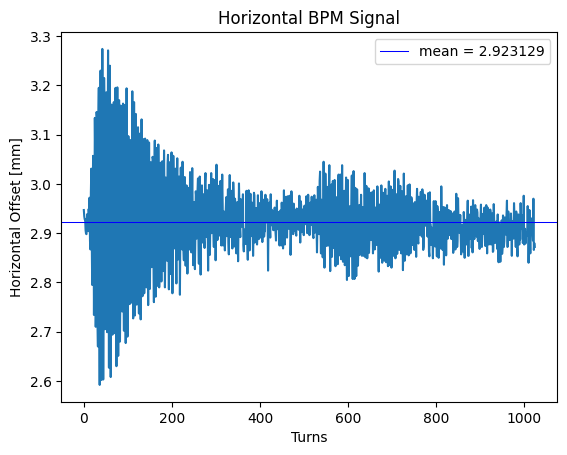

Standard deviation of Vertical BPM = 0.14039846131415454


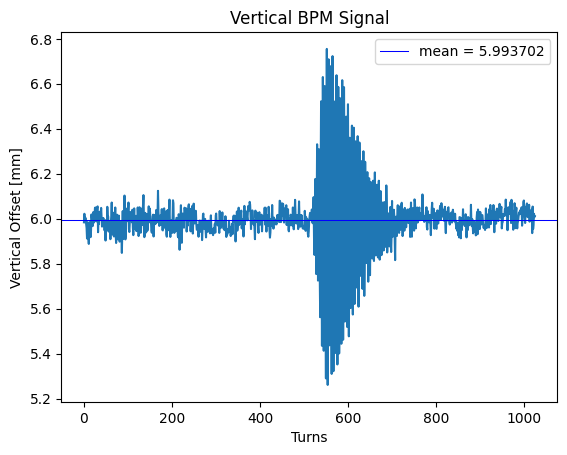

In [4]:
BPMx0 = BPMx[0]

BPMx0_mean = np.mean(BPMx0)
BPMx0_std = np.std(BPMx0)
print("Standard deviation of Horizontal BPM =", BPMx0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMx0)
plt.axhline(y = BPMx0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMx0_mean)
plt.xlabel("Turns")
plt.ylabel("Horizontal Offset [mm]")
plt.title("Horizontal BPM Signal")
plt.legend()
plt.show()

BPMy0 = BPMy[0]

BPMy0_mean = np.mean(BPMy0)
BPMy0_std = np.std(BPMy0)
print("Standard deviation of Vertical BPM =", BPMy0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMy0)
plt.axhline(y = BPMy0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMy0_mean)
plt.xlabel("Turns")
plt.ylabel("Vertical Offset [mm]")
plt.title("Vertical BPM Signal")
plt.legend()
plt.show()

0.23483365949119372


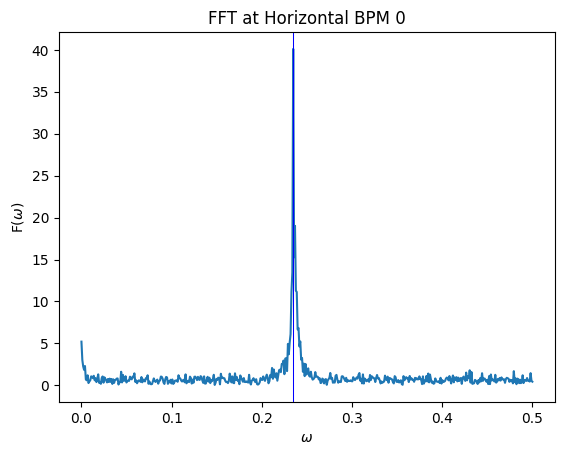

0.22896281800391388


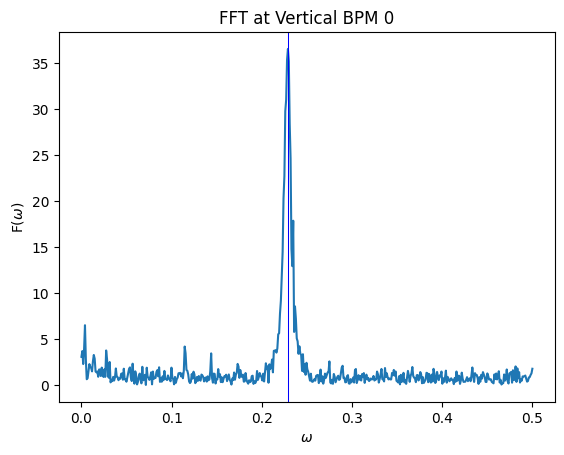

In [5]:
BPMX0 = np.abs(fft.rfft(BPMx0)[1:])
BPMx0_Tune_scipy = Omega[np.argmax(BPMX0)]
print(BPMx0_Tune_scipy)
plt.plot(Omega, BPMX0)
plt.axvline(x = BPMx0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%BPMx0_Tune_scipy)
plt.title("FFT at Horizontal BPM 0")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()
# plt.plot(Omega, np.abs(fft.fft(BPMx0)[1:N_turns//2 + 1]))
# plt.show()
# print(len(np.imag(fft.fft(BPMx0)[1:N_turns//2 + 1])))

BPMY0 = np.abs(fft.rfft(BPMy0)[1:])
BPMy0_Tune_scipy = Omega[np.argmax(BPMY0)]
print(BPMy0_Tune_scipy)
plt.plot(Omega, BPMY0)
plt.axvline(x = BPMy0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%BPMy0_Tune_scipy)
plt.title("FFT at Vertical BPM 0")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

0.00016808850880467574 0.0010185889772997558


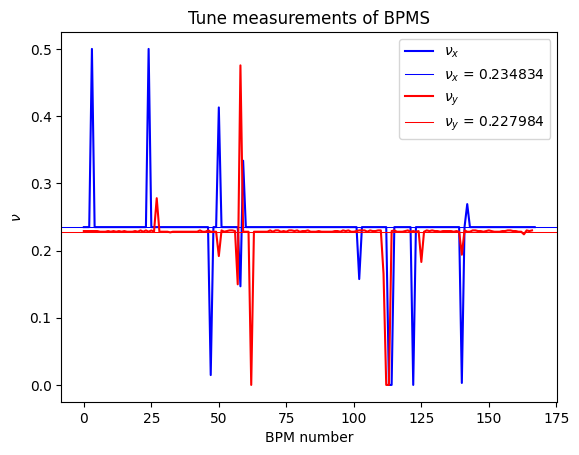

In [6]:
# Scipy to figure out tune
BPMx_Tune_Map = np.zeros(N_BPMx)
for i in range(N_BPMx):
    BPMX = np.abs(fft.rfft(BPMx[i])[1:]) 
    BPMx_Tune_Map[i] = Omega[np.argmax(BPMX)]
    # BPM 113 had a flat line

BPMy_Tune_Map = np.zeros(N_BPMy)
for i in range(N_BPMy):
    BPMY = np.abs(fft.rfft(BPMy[i])[1:])
    BPMy_Tune_Map[i] = Omega[np.argmax(BPMY)]

nu_x, nu_y = st.mode(BPMx_Tune_Map), st.mode(BPMy_Tune_Map)
#Difference from experiment
delta_nu_x, delta_nu_y = abs(nu_x_meas - nu_x), abs(nu_y_meas - nu_y)
print(delta_nu_x, delta_nu_y)

plt.plot(BPMx_Tune_Map, color = 'b', label = r"$\nu_x$")
plt.axhline(y = nu_x, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%nu_x)
plt.plot(BPMy_Tune_Map, color = 'r', label = r"$\nu_y$")
plt.axhline(y = nu_y, color = 'r', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%nu_y)
plt.xlabel("BPM number")
plt.ylabel(r"$\nu$")
plt.title("Tune measurements of BPMS")
plt.legend()
plt.show()

In [7]:
def Bad_Bpms(Tune_Map, nu, N_BPM):
    Tune_Offset = np.abs(Tune_Map - np.ones(N_BPM)*nu)
    Bad_BPM = []
    for i, offset in enumerate(Tune_Offset):
        if offset > .01:
            Bad_BPM.append(i)
    return Bad_BPM

Bad_BPMx = Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx)
Bad_BPMy = Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy)
print(Bad_BPMx)
print(Bad_BPMy)

[3, 24, 47, 50, 58, 59, 102, 113, 114, 122, 140, 142]
[27, 50, 57, 58, 62, 111, 112, 113, 125, 140]


# Betatron Function in terms of $A^2$

In [8]:
# Castro Paper
def Castro(nu, N_BPMs, Bad_bpms, BPM):
    
    omega = 2*np.pi*nu
    I = np.linspace(0, N_turns - 1, N_turns)
    C = np.sum(BPM*np.cos(omega*I), axis = 1)
    S = np.sum(BPM*np.sin(omega*I), axis = 1)
    A = 2*np.sqrt(C**2 + S**2)/N_turns

    # Get rid of bad bpms
    for i in Bad_bpms:
        # Look for the nearest good bpm neighbors and take the average:
        lo, hi = i, i
        while lo in Bad_bpms: 
            lo -= 1
            if lo < 0: lo = N_BPMs - 1
        while hi in Bad_bpms: 
            hi += 1
            if hi >= N_BPMs: hi = 0
        A[i] = (A[lo] + A[hi])/2
    return A

BPMx_A_Map = Castro(nu_x, N_BPMx, Bad_BPMx, BPMx)
BPMy_A_Map = Castro(nu_y, N_BPMy, Bad_BPMy, BPMy)

g7-bx g8-bx


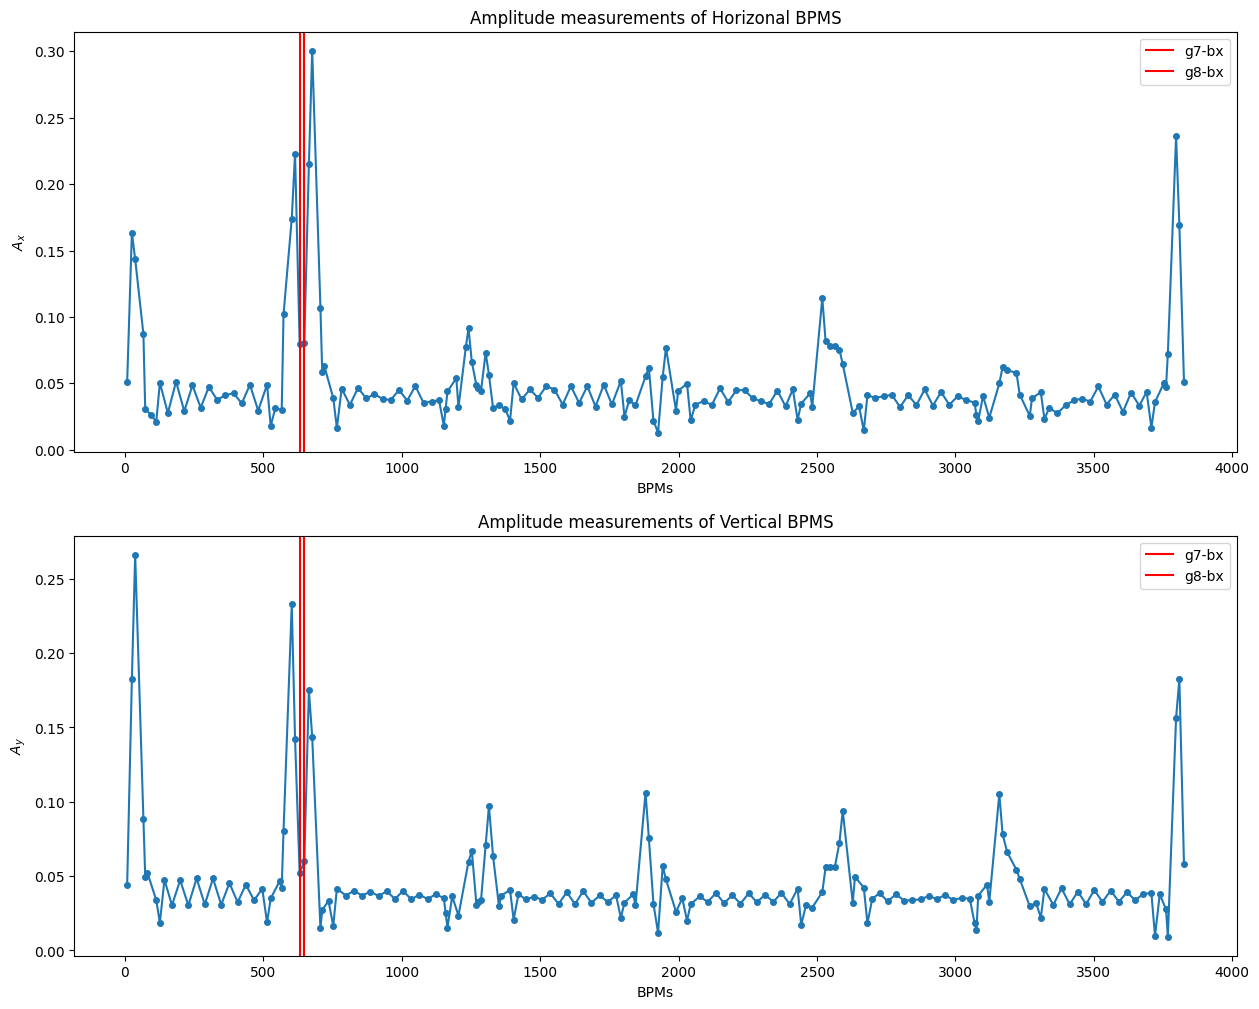

In [187]:
# Plot
fig, Ax = plt.subplots(2, 1, figsize = (15, 12))
init_bpmx = 0
final_bpmx = N_BPMx
x_BPM = np.linspace(0, N_BPMx, N_BPMx + 1)
Ax[0].plot(S_xbpms[0][init_bpmx: final_bpmx], BPMx_A_Map[init_bpmx: final_bpmx], '-o', ms = 4)
Ax[0].set_xlabel("BPMs")
Ax[0].set_ylabel(r"$A_x$")
Ax[0].set_title(r"Amplitude measurements of Horizonal BPMS")

g7_bx = Name_xbpms[27]
g8_bx = Name_xbpms[28]
Ax[0].axvline(x = S_xbpms[0][27], color = 'r', linestyle = '-', label = g7_bx)
Ax[0].axvline(x = S_xbpms[0][28], color = 'r', linestyle = '-', label = g8_bx)
Ax[0].legend()

init_bpmy = 0
final_bpmy = N_BPMy
y_BPM = np.linspace(0, N_BPMy, N_BPMy + 1)
Ax[1].plot(S_ybpms[0][init_bpmy: final_bpmy], BPMy_A_Map[init_bpmy: final_bpmy], '-o', ms = 4)
Ax[1].set_xlabel("BPMs")
Ax[1].set_ylabel(r"$A_y$")
Ax[1].set_title(r"Amplitude measurements of Vertical BPMS")

print(Name_ybpms[28], Name_ybpms[29])
Ax[1].axvline(x = S_ybpms[0][28], color = 'r', linestyle = '-', label = g7_bx)
Ax[1].axvline(x = S_ybpms[0][29], color = 'r', linestyle = '-', label = g8_bx)
Ax[1].legend()

plt.show()

# Betatron Function around IP8

## Method 1:
Determine constant a from $\beta = \frac{A^2}{a^2}$

\begin{equation*}
M_{drift} = 
\begin{bmatrix}
C & S\\
C' & S'
\end{bmatrix}
=
\begin{bmatrix}
1 & L\\
0 & 1
\end{bmatrix}
\end{equation*}

\begin{equation*}
\Rightarrow
M_{twiss} = 
\begin{bmatrix}
1 & -2L & L^2 \\
0 & 1 & -L \\
0 & 0 & 1
\end{bmatrix}
\end{equation*}

Between BPM 27 and BPM 28:
\begin{equation*}
\begin{bmatrix}
\beta_2 \\
\alpha_f \\
\gamma_f \\
\end{bmatrix}
= 
\begin{bmatrix}
1 & -2L & L^2 \\
0 & 1 & -L \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\alpha_i \\
\gamma_i \\
\end{bmatrix}
\end{equation*}

$\Rightarrow \beta_2 = \beta_1 - 2L\alpha_i + L^2 \gamma_i$\
$\Rightarrow \alpha_1 = \frac{\beta_1}{L} \pm \sqrt{\frac{\beta_1\beta_2}{L^2} - 1}$\
$\Rightarrow \alpha_2 = \alpha_1 - L\gamma_1$\
Where $\gamma_1 = \frac{1 + \alpha_1^2}{\beta_1}$

Between BPM 26 and BPM 27:\
\begin{equation*}
\begin{bmatrix}
\beta_1 \\
\alpha_1 \\
\gamma_1 \\
\end{bmatrix}
= 
\begin{bmatrix}
1 & -2L & L^2 \\
0 & 1 & -L \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\beta_0 \\
\alpha_i \\
\gamma_i \\
\end{bmatrix}
\end{equation*}
$\Rightarrow 0 = \beta_1 - \beta_0 - 2L\alpha_1 - L^2 \gamma_1$


Or between BPM 28 and BPM 29:\
\begin{equation*}
\begin{bmatrix}
\beta_3 \\
\alpha_f \\
\gamma_f \\
\end{bmatrix}
= 
\begin{bmatrix}
1 & -2L & L^2 \\
0 & 1 & -L \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\beta_2 \\
\alpha_2 \\
\gamma_2 \\
\end{bmatrix}
\end{equation*}
$\Rightarrow 0 = \beta_2 - \beta_3 - 2L\alpha_2 + L^2 \gamma_2$

Since everything is known except a, solve for a using some root finding method

This method is ok since accelerator methods are used, but we cannot fit the a constant perfectly since the machine is not perfect. Therefore root finding methods may not be perfect/ not work.\
After trying to fit the constant, determine b* and s* and fit a parabola onto the curve using the three points:\
($s_{g7-bx}, \beta(s_{g7-bx}$)), ($s^*, \beta^*$), ($s_{g8-bx}$, $\beta(s_{g8-bx}$))

In [188]:
print(Name_xbpms[27])
print(S_xbpms[0, 27])
a = 0.01810292126599353
b26 = (BPMx_A_Map[26]/a)**2
b27 = (BPMx_A_Map[27]/a)**2
b28 = (BPMx_A_Map[28]/a)**2
b29 = (BPMx_A_Map[29]/a)**2
print(b26, b27, b28, b29)

g7-bx
631.118713
151.568200864554 19.528837907694655 19.84025185537016 141.34415148196481


/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_4285/1653962480.py:14: RuntimeWarning: invalid value encountered in sqrt
  alpha27 = b27/L27_28 + np.sqrt(b27*b28/L27_28**2 - 1)


12098.618055408591 -28.995850873276687
12098.618055408591


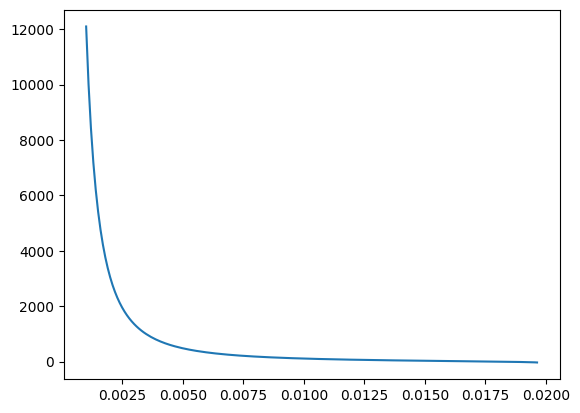

0.01810414630938612


In [189]:
s_bo7_b1 = S_xbpms[0, 26]
s_g7_bx = S_xbpms[0, 27]
s_g8_bx = S_xbpms[0, 28]
s_bi8_b1 = S_xbpms[0, 29]
L26_27 = abs(s_g7_bx - s_bo7_b1)
L27_28 = abs(s_g8_bx - s_g7_bx)
L28_29 = abs(s_bi8_b1 - s_g8_bx)

def f(a):
    b26 = (BPMx_A_Map[26]/a)**2
    b27 = (BPMx_A_Map[27]/a)**2
    b28 = (BPMx_A_Map[28]/a)**2
    b29 = (BPMx_A_Map[29]/a)**2
    alpha27 = b27/L27_28 + np.sqrt(b27*b28/L27_28**2 - 1)
    gamma27 = (1 + alpha27**2)/b27
    alpha28 = alpha27 - L27_28*gamma27
    gamma28 = (1 + alpha28**2)/b28
    return b28 - b29 - 2*L28_29*alpha28 + L28_29**2*gamma28
#     return b26 - b27 - 2*L26_27*alpha27 - L26_27**2*gamma27
    

A_const = np.linspace(.001, .1, 1000)
f_a = f(A_const)
f_a = f_a[np.logical_not(np.isnan(f_a))]
N_f_a = len(f_a)
print(f_a[0], f_a[-1])
print(np.max(f_a))
plt.plot(A_const, f(A_const))
plt.show()

a_opt = optimize.bisect(f, A_const[0], A_const[-1])
print(a_opt)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


After shift:


<IPython.core.display.Math object>

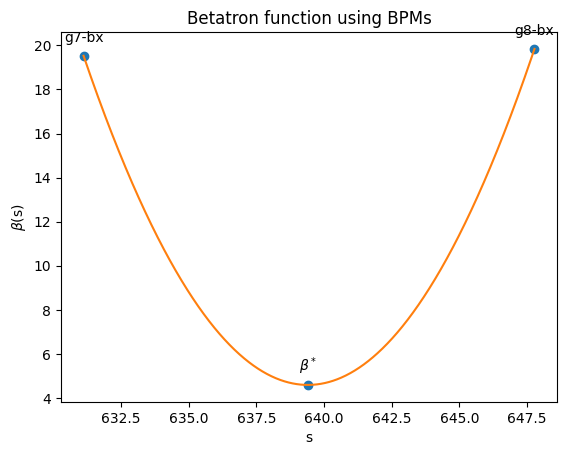

In [190]:
# Determine Betatron function:
a_const = a_opt
beta_BPM27, beta_BPM28 = (BPMx_A_Map[27]/a_const)**2, (BPMx_A_Map[28]/a_const)**2
alpha_BPM27 = beta_BPM27/L27_28 + np.sqrt(beta_BPM27*beta_BPM28/L27_28**2 - 1)
display(Math(r"\beta_{27} = %f"%beta_BPM27))
display(Math(r"\alpha_{27} = %f"%alpha_BPM27))
display(Math(r"\beta_{28} = %f"%beta_BPM28))
 
s_star = s_g7_bx + alpha_BPM27*beta_BPM27/(alpha_BPM27**2 + 1)
beta_star = beta_BPM27/(alpha_BPM27**2 + 1)
display(Math(r"\beta^* = %f"%beta_star))
display(Math(r"s^* = %f"%s_star))
sIP8 = 639.445027949618
display(Math(r"\Delta s^* = %f"%(s_star - sIP8)))

def calc_parabola_vertex(x1, y1, x2, y2, x3, y3):
    denom = (x1-x2) * (x1-x3) * (x2-x3)
    A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom
    B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom
    C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom
    return A,B,C
A, B, C = calc_parabola_vertex(s_g7_bx, beta_BPM27, s_star, beta_star, s_g8_bx, beta_BPM28)
A_shift, B_shift, C_shift = calc_parabola_vertex(s_g7_bx - s_star, beta_BPM27, 0, beta_star, s_g8_bx - s_star, beta_BPM28)
print()
print("After shift:")
display(Math(r"%fx^2 + %dx + %f"%(A_shift, B_shift, C_shift)))

s_space = np.linspace(s_g7_bx, s_g8_bx, 1000)
Betatron = A*s_space**2 + B*s_space + C
plt.plot([s_g7_bx, s_star, s_g8_bx], [beta_BPM27, beta_star, beta_BPM28], 'o')
for x, y, text in zip([s_g7_bx, s_star, s_g8_bx], [beta_BPM27, beta_star, beta_BPM28], 
                      [Name_xbpms[27], r"$\beta^*$", Name_xbpms[28]]):

    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.plot(s_space, Betatron)
plt.title("Betatron function using BPMs")
plt.xlabel("s")
plt.ylabel(r"$\beta$(s)")
plt.show()


## Method 2:
This method uses curve_fit to fit four points:

($s_{bo7_b1}, \beta(s_{bo7_b1}$)), ($s_{g7-bx}, \beta(s_{g7-bx}$)), ($s_{g8-bx}$, $\beta(s_{g8-bx}$)), ($s_{bi8_b1}$, $\beta(s_{bi8_b1}$))

to a general parabola. This method is not that great since the shape between the two BPMs near IP may not depend on the ones next to it.

In [191]:
def model(x, A, B, C): 
    return A*x**2 + B*x + C 
X = np.array([s_bo7_b1, s_g7_bx, s_g8_bx, s_bi8_b1])
Y = BPMx_A_Map[26:30]
Fit, Covar, = optimize.curve_fit(model, X, Y)
print(Fit)
print(Covar)

[ 2.49127334e-04 -3.18740256e-01  1.02014256e+02]
[[ 1.46812797e-11 -1.87757406e-08  5.99792081e-06]
 [-1.87757406e-08  2.40153781e-05 -7.67277323e-03]
 [ 5.99792081e-06 -7.67277323e-03  2.45174251e+00]]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

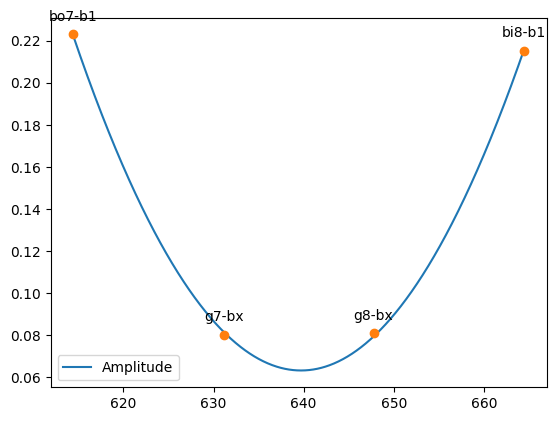

12.12012337304196


In [192]:
s_space = np.linspace(s_bo7_b1, s_bi8_b1, 1000)
Betatron = Fit[0]*s_space**2 + Fit[1]*s_space + Fit[2]
s_star = s_space[np.argmin(Betatron)]
display(Math(r"s^* = %f"%s_star))
display(Math(r"\Delta s^* = %f"%(s_star - sIP8)))
plt.plot(s_space, Betatron, label = 'Amplitude')
plt.plot(X, Y, 'o')
for x, y, text in zip(X, Y, Name_xbpms[26:30]):
    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
# plt.axvline(x = s_star, color = 'black', label = 's*')
# plt.axvline(x = mid, color = 'blue', label = 'mid')
plt.legend()
plt.show()
print((Betatron[np.argmin(Betatron)]/a_const)**2)

## Method 3:
Solve for three nonlinear equations and three unknowns: $\beta^*, s^*, a$\
Using:\
0 = $\beta^* + (s_{g7-bx} - s^*)^2/\beta^* - \beta(s_{g7-bx})$\
0 = $\beta^* + (s_{g8-bx} - s^*)^2/\beta^* - \beta(s_{g8-bx})$\
0 = $\sqrt{|\beta(s_{g7-bx})\beta(s_{g8-bx}) - 1|} - ((s^* - s_{g7-bx})/\beta^* - \beta(s_{g7-bx})/L_{27-28}))$

Third equation comes from alpha equation from method 1.\
It produces many solutions based on the guess of $\beta^*$ and a, so look at L2 error of each combination.\
Look at the result with the lowest error first. Then create histograms and weighted histograms to see where the solution should be. The average and standard deviations after weighting with the L2 error should be a more accurate picture of where the solution lies.

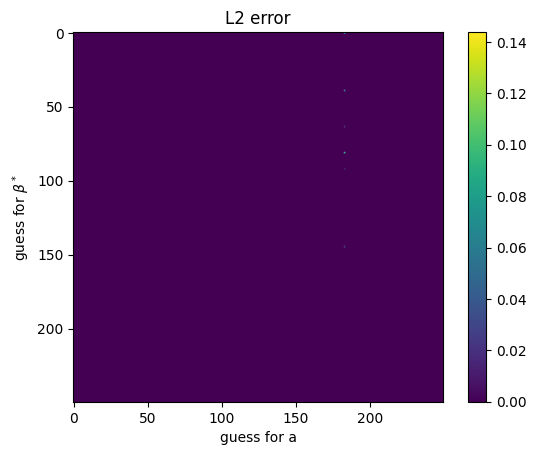

Lowest error result


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [193]:
def f2(x):
    sstar, bstar, a = x
    b27 = (BPMx_A_Map[27]/a)**2
    b28 = (BPMx_A_Map[28]/a)**2
    return np.array([
           bstar + (s_g7_bx - sstar)**2/bstar - b27, 
           bstar + (s_g8_bx - sstar)**2/bstar - b28,
           np.sqrt(abs(b27*b28/L27_28**2 - 1)) - ((sstar - s_g7_bx)/bstar - b27/L27_28)])

# a_guess = .01
# sstar, bstar, aconst = optimize.fsolve(f2, [mid, 1, a_guess])
# print(sstar, bstar, aconst)
# print(f2([sstar, bstar, a]))

#accuracy:
N_b = 250
N_a = 250

Bguess = np.linspace(.1, 5, N_b)
Aguess = np.linspace(.005, .025, N_a)
Err = np.zeros([N_b, N_a])

Sstar = np.zeros([N_b, N_a])
Bstar = np.zeros([N_b, N_a])
Aconst = np.zeros([N_b, N_a])
for i, b in enumerate(Bguess):
    for j, a in enumerate(Aguess):
        sstar, bstar, aconst = optimize.fsolve(f2, [sIP8, b, a])
        Err[i, j] = np.sqrt(np.sum(f2([sstar, bstar, aconst])**2))
        Sstar[i, j] = sstar
        Bstar[i, j] = bstar
        Aconst[i, j] = aconst
c = plt.imshow(Err)
plt.title("L2 error")
plt.xlabel("guess for a")
plt.ylabel(r"guess for $\beta^*$")
plt.colorbar(c)
plt.show()

# plt.imshow(Bguess, Aguess, Bstar)
# plt.ylabel("Bstar")
# plt.xlabel(r"guess for $\beta^*$")
# plt.show()
b_ind, a_ind = np.unravel_index(np.argmin(Err), Err.shape)
sstar, bstar, aconst = optimize.fsolve(f2, [sIP8, Bguess[b_ind], Aguess[a_ind]])
print("Lowest error result")
display(Math(r"s^* = %f, \beta^* = %f, a = %f"%(sstar, bstar, aconst)))
display(Math(r"\Delta s^* = %f"%(sstar - sIP8)))

639.4058921232876 0.007847832565151919
2.9505765005495976 2.091877104391646
0.013964279321393847 0.004107551999811253
-0.03913582633038004


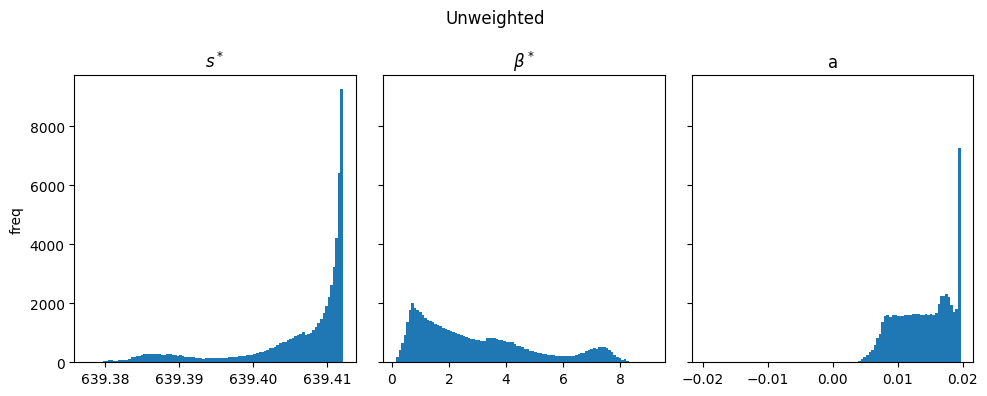

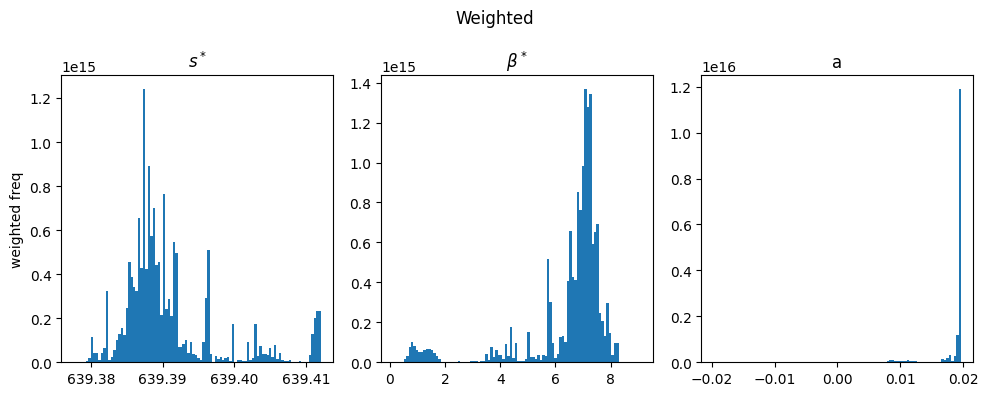

In [194]:
print(np.mean(Sstar), np.std(Sstar))
print(np.mean(Bstar), np.std(Bstar))
print(np.mean(Aconst), np.std(Aconst))
print(np.mean(Sstar) - sIP8)

bins = 100
fig, axs = plt.subplots(1, 3, sharey = True, tight_layout=True, figsize = (10, 4))
plt.suptitle("Unweighted")
axs[0].hist(Sstar.flatten(), bins)
axs[1].hist(Bstar.flatten(), bins)
axs[2].hist(Aconst.flatten(), bins)
axs[0].set_ylabel("freq")
axs[0].set_title(r"$s^*$")
axs[1].set_title(r"$\beta^*$")
axs[2].set_title("a")
plt.show()

fig, axs = plt.subplots(1, 3, tight_layout=True, figsize = (10, 4))
plt.suptitle("Weighted")
freq_Sstar_weight, bins_Sstar_weight, _ = axs[0].hist(Sstar.flatten(), bins, weights = 1/Err.flatten())#, density = True)
freq_Bstar_weight, bins_Bstar_weight, _ = axs[1].hist(Bstar.flatten(), bins, weights = 1/Err.flatten())#, density = True)
freq_Aconst_weight, bins_Aconst_weight, _ = axs[2].hist(Aconst.flatten(), bins, weights = 1/Err.flatten())#, density = True)
axs[0].set_ylabel("weighted freq")
axs[0].set_title(r"$s^*$")
axs[1].set_title(r"$\beta^*$")
axs[2].set_title("a")
plt.show()

In [195]:
# Find mean and stddev of three plots
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, np.sqrt(variance)
print(weighted_avg_and_std(bins_Sstar_weight[:-1], freq_Sstar_weight))
print(weighted_avg_and_std(bins_Bstar_weight[:-1], freq_Bstar_weight))
print(weighted_avg_and_std(bins_Aconst_weight[:-1], freq_Aconst_weight))
print(weighted_avg_and_std(bins_Sstar_weight[:-1], freq_Sstar_weight)[0] - sIP8)

(639.3907445418088, 0.006998038936856799)
(6.445519372312039, 1.5548830813172072)
(0.018614634053552438, 0.0021991924236350693)
-0.05428340780918006


## Guillaume's Method

In [199]:
s_MADx = []
Betax_MADx = []
with open('twiss.out_Au23-100GeV-e0-beta5') as output:
    Lines = output.readlines()
    for i, line in enumerate(Lines[48:]):
        Line = re.split("\s+", line)
        s_MADx.append(float(Line[2]))
        Betax_MADx.append(float(Line[3]))

s_MADx = np.array(s_MADx)
Betax_MADx = np.array(Betax_MADx)
print(s_MADx[:20])
print(Betax_MADx[:20])

[ 0.          7.99309     7.99309     9.8         9.8         9.8
 13.50021938 13.50021938 13.50021938 15.78200001 15.78200001 17.58400001
 17.58400001 20.50711317 20.50711317 24.09607941 24.09607941 25.02378317
 25.02378317 25.36072797]
[  4.84502906  17.31938044  17.31938044  23.80198488  23.80198488
  23.80198488  41.27979317  41.27979317  41.27979317  54.87821894
  54.87821894  67.13796285  67.13796285  89.87911572  89.87911572
 122.6042446  122.6042446  131.9206985  131.9206985  135.3922625 ]
3031


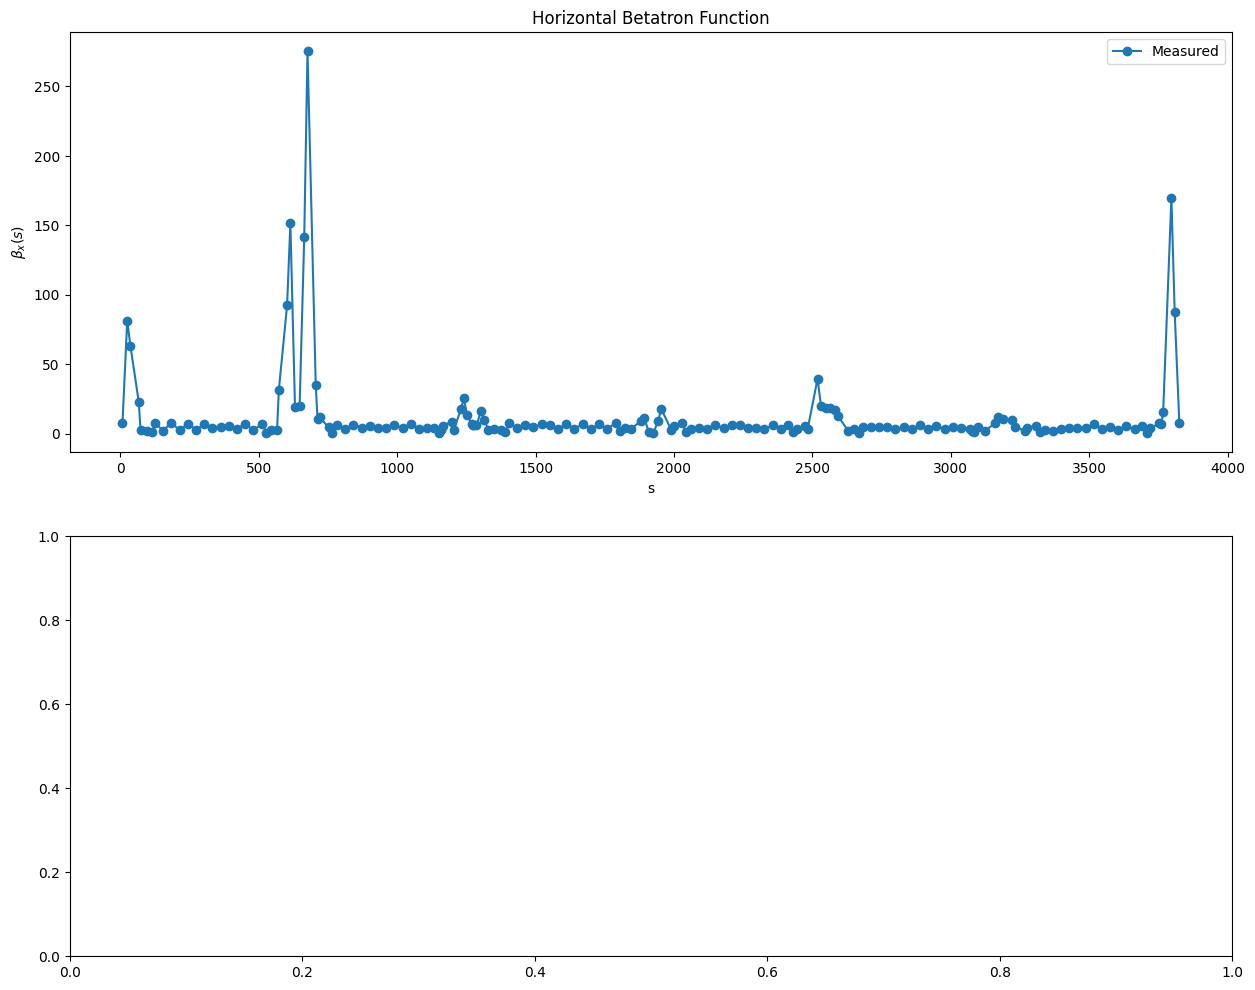

In [186]:
# Plot Betatron function and compare to actual betatron function
fig, Ax = plt.subplots(2, 1, figsize = (15, 12))
BPMx_betatron_Map = (BPMx_A_Map/a_const)**2

#Ax[0].plot(s_MADx, Betax_MADx, label = "MADx")
Ax[0].plot(S_xbpms[0], BPMx_betatron_Map, '-o', label = "Measured")

Ax[0].set_xlabel("s")
Ax[0].set_ylabel(r"$\beta_x(s)$")
#Ax[0].set_ylim([0, 10])
Ax[0].set_title(r"Horizontal Betatron Function")
Ax[0].legend()
plt.show()